In [1]:
import tensorflow as tf
import polars as pl
import numpy as np
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from window_generator import WindowGenerator

2023-03-31 14:49:12.213372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 14:49:12.257188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 14:49:12.258298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 14:49:13.189806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pl.read_csv("../data/prices/F_prices.csv")

# clean data
df.drop_in_place('Date')

# split data
train_df, val_df, test_df = utils.split_train_val_test(df, .7, .2)

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = train_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

val_df = val_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

test_df = test_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])


[Text(0, 0, 'Price'), Text(1, 0, 'Volume')]

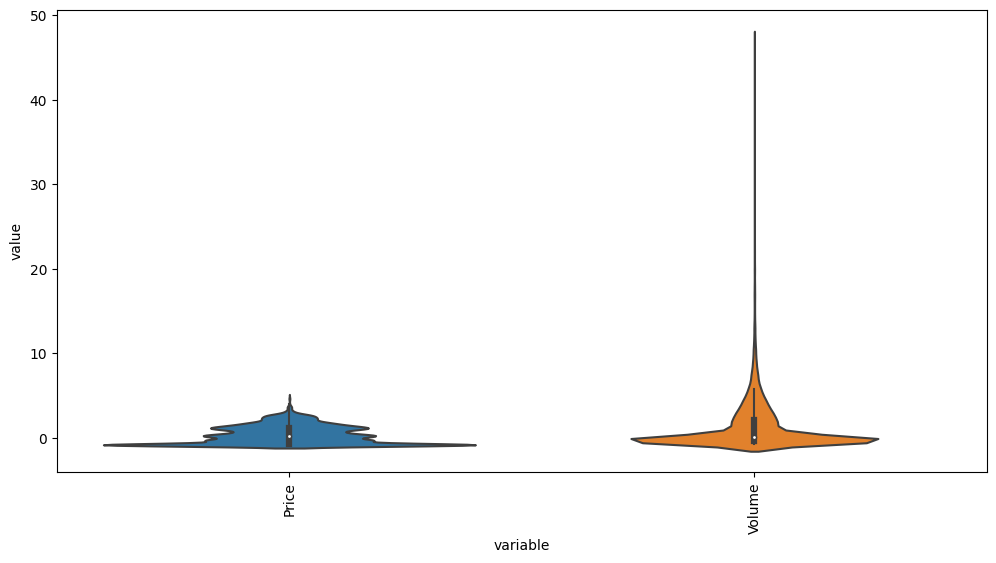

In [3]:
df_std = df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])
df_std = df_std.melt(value_vars=df_std.columns)
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='variable', y='value', data=df_std.to_pandas())
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

In [4]:
window = WindowGenerator(input_width=10, label_width=10, shift=1, label_columns=['Price'], train_df=train_df, val_df=val_df, test_df=test_df)

window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['Price']

In [5]:
example_window = tf.stack([train_df[:window.total_window_size].to_numpy(),
                           train_df[100:100+window.total_window_size].to_numpy(),
                           train_df[200:200+window.total_window_size].to_numpy()])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 11, 2)
Inputs shape: (3, 10, 2)
Labels shape: (3, 10, 1)


2023-03-31 14:49:15.723760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-31 14:49:15.724621: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [7]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)


2023-03-31 14:49:16.018296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8972,2]
	 [[{{node Placeholder/_0}}]]
2023-03-31 14:49:16.018822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


Input shape: (32, 10, 2)
Output shape: (32, 10, 1)


2023-03-31 14:49:16.371226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-31 14:49:16.373309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-31 14:49:16.374697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

history = lstm_model.fit(window.train, epochs=20,
                         validation_data=window.val,
                         callbacks=[early_stopping])

Epoch 1/20


2023-03-31 14:49:16.968128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-03-31 14:49:16.968482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8972,2]
	 [[{{node Placeholder/_0}}]]
2023-03-31 14:49:17.391243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

272/281 [============================>.] - ETA: 0s - loss: 0.2975 - mean_absolute_error: 0.3238

2023-03-31 14:49:21.101577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2554]
	 [[{{node Placeholder/_8}}]]
2023-03-31 14:49:21.101973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2554]
	 [[{{node Placeholder/_8}}]]
2023-03-31 14:49:21.330281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' wi

281/281 [==============================] - 5s 8ms/step - loss: 0.2910 - mean_absolute_error: 0.3187 - val_loss: 0.2134 - val_mean_absolute_error: 0.3430
Epoch 2/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0513 - mean_absolute_error: 0.1113 - val_loss: 0.1107 - val_mean_absolute_error: 0.2236
Epoch 3/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0193 - mean_absolute_error: 0.0660 - val_loss: 0.0669 - val_mean_absolute_error: 0.1626
Epoch 4/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0065 - mean_absolute_error: 0.0421 - val_loss: 0.0441 - val_mean_absolute_error: 0.1275
Epoch 5/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0284 - val_loss: 0.0298 - val_mean_absolute_error: 0.1028
Epoch 6/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0237 - val_loss: 0.0226 - val_mean_absolute_error: 0.0897
Epoch 7/20
281/281 [=======

In [10]:
IPython.display.clear_output()
val_performance_lstm = lstm_model.evaluate(window.val)
performance_lstm = lstm_model.evaluate(window.test, verbose=0)

42/80 [==============>...............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0508

2023-03-31 14:49:57.090620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2564,2]
	 [[{{node Placeholder/_0}}]]
2023-03-31 14:49:57.091090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2564,2]
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0505


2023-03-31 14:49:57.402732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1272]
	 [[{{node Placeholder/_8}}]]
2023-03-31 14:49:57.403173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


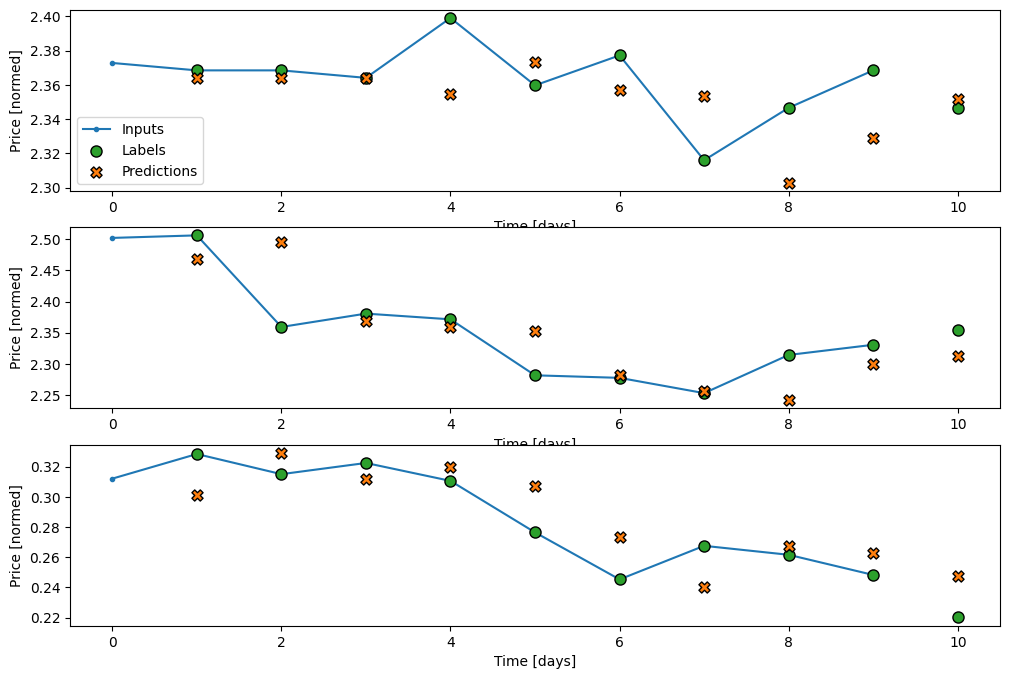

In [11]:
window.plot(lstm_model)